In [16]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import datetime
import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matlab.engine
import time
import random
from numpy.random import randn
from numpy.random import rand

In [17]:
class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = self.flatten(x)
        # print(x.size())
        # print('forward')
        x = self.fc1(x)
        # print('forward1')
        x = self.fc2(x)
        # print('forward3')
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.tensor(state).float().unsqueeze(0).to(device)
        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)


In [18]:
def reinforce(OSNR, M, policy, optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []

    # Connect to matlab
    eng = matlab.engine.start_matlab()
    eng.cd(r'/home/reedvl/Desktop/Nokia/Simulation/BlackBox/QAMBlackBox_Daria', nargout=0)
    
     # Create file with current timestamp
    current_date_and_time = datetime.datetime.now()
    current_date_and_time_string = str(current_date_and_time)
    extension = ".txt"
    file_name =  current_date_and_time_string + extension
    f = open(file_name, "a")
    
    rs = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state, init_mi = eng.init(M, OSNR, nargout=2)
        print('i got the init')
        mis = [0]*max_t
        actions = [0]*max_t
        best_mi = 0
        broken_loop = False

        tic = time.perf_counter()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, mi, done = eng.mi(action, state, OSNR, init_mi, nargout = 4)
            mis[t] = mi
            actions[t] = action
            rewards.append(reward)
            
            print('action', action, 't', t, 'ep:', i_episode, 'mi', round(mi, 2), 'reward', round(reward, 2), 'cum', round(sum(rewards), 2))
            if mi > best_mi:
                best_mi = mi
                
            # if actions[t] == actions[t-1] and t > 5:
            #     if actions[t] == actions[t-2]:
            #         if actions[t] == actions[t-3]:
            #             break
            # Plot the new constellation
            # np_state = np.array(state)
            # x = np.zeros(len(np_state))
            # y = np.zeros(len(np_state))
            # for i in range(len(np_state)):
            #     x[i] = np_state[i, 0]
            #     y[i] = np_state[i, 1]
            
            # plt.plot(x, y, 'ro')
            # plt.show()
            
            # print('mi', mi)
            if done:
                broken_loop = True
                break
        
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        rs.append(float(policy_loss))
        
        # Save all the data
        f.write('state: ')
        f.write(str(state))
        f.write('rewards: ')
        f.write(str(rewards))
        f.write('\n')
        f.write('scores: ')
        f.write(str(scores))
        f.write('\n')
        f.write('policy loss: ')
        f.write(str(policy_loss))
        f.write('\n')
        f.write('best_mi: ')
        f.write(str(best_mi))
        f.write('\n')
        if broken_loop:
            f.write('BROKE THE LOOP')
            f.write('\n')
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        episodes = [i for i in range(i_episode)]
        plt.plot(episodes, scores, '.-')
        plt.xlabel('Episode')
        plt.ylabel('Score')
        # plt.savefig('scores_2.png')
        plt.show()
        
        toc = time.perf_counter()
        print(f"RL episode performed in {toc - tic:0.4f} seconds")

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
    f.close()
    print(scores)
    
    episodes = [i for i in range(n_episodes)]
    plt.plot(np.arange(1, len(saved_log_probs)+1), saved_log_probs)
    plt.xlabel('Episode')
    plt.ylabel('Policy loss')
    plt.savefig('rewards_1.png')
    plt.show()
    
    model_name = current_date_and_time_string + '_model' + '.pth'
    torch.save({
        'episode': n_episodes,
        'max_t': max_t,
        'model_state_dict': policy.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, model_name)
    
    return scores

i got the init
action 52 t 0 ep: 1 mi 2.66 reward -0.0 cum -0.0
action 50 t 1 ep: 1 mi 2.66 reward -0.0 cum -0.0
action 2 t 2 ep: 1 mi 2.66 reward -0.01 cum -0.01
action 19 t 3 ep: 1 mi 2.65 reward -0.01 cum -0.02
action 4 t 4 ep: 1 mi 2.65 reward -0.02 cum -0.04
action 62 t 5 ep: 1 mi 2.65 reward -0.02 cum -0.06
action 21 t 6 ep: 1 mi 2.64 reward -0.02 cum -0.08
action 59 t 7 ep: 1 mi 2.65 reward -0.02 cum -0.1
action 62 t 8 ep: 1 mi 2.65 reward -0.02 cum -0.11
action 50 t 9 ep: 1 mi 2.64 reward -0.02 cum -0.13
action 54 t 10 ep: 1 mi 2.65 reward -0.01 cum -0.15
action 51 t 11 ep: 1 mi 2.65 reward -0.02 cum -0.16
action 29 t 12 ep: 1 mi 2.65 reward -0.02 cum -0.18
action 60 t 13 ep: 1 mi 2.65 reward -0.02 cum -0.2
action 25 t 14 ep: 1 mi 2.65 reward -0.02 cum -0.22
action 15 t 15 ep: 1 mi 2.65 reward -0.01 cum -0.23
action 2 t 16 ep: 1 mi 2.65 reward -0.02 cum -0.25
action 48 t 17 ep: 1 mi 2.65 reward -0.01 cum -0.26
action 39 t 18 ep: 1 mi 2.66 reward -0.01 cum -0.27
action 15 t 19 e

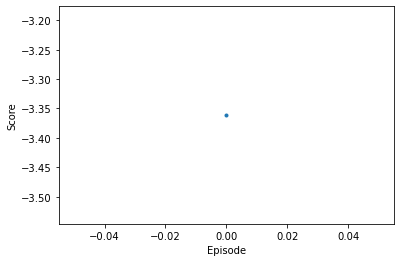

RL episode performed in 399.7184 seconds
Episode 1	Average Score: -3.36
i got the init
action 20 t 0 ep: 2 mi 2.67 reward 0.01 cum 0.01
action 52 t 1 ep: 2 mi 2.65 reward -0.01 cum 0.0
action 43 t 2 ep: 2 mi 2.66 reward -0.0 cum -0.0
action 12 t 3 ep: 2 mi 2.65 reward -0.01 cum -0.01
action 30 t 4 ep: 2 mi 2.66 reward 0.0 cum -0.01
action 0 t 5 ep: 2 mi 2.66 reward 0.0 cum -0.01
action 15 t 6 ep: 2 mi 2.67 reward 0.0 cum -0.0
action 9 t 7 ep: 2 mi 2.67 reward 0.01 cum 0.0
action 9 t 8 ep: 2 mi 2.66 reward 0.0 cum 0.01
action 11 t 9 ep: 2 mi 2.67 reward 0.01 cum 0.01
action 57 t 10 ep: 2 mi 2.67 reward 0.01 cum 0.02
action 47 t 11 ep: 2 mi 2.67 reward 0.0 cum 0.02
action 26 t 12 ep: 2 mi 2.66 reward -0.0 cum 0.02
action 38 t 13 ep: 2 mi 2.67 reward 0.01 cum 0.03
action 52 t 14 ep: 2 mi 2.66 reward -0.01 cum 0.02
action 32 t 15 ep: 2 mi 2.66 reward -0.0 cum 0.02
action 54 t 16 ep: 2 mi 2.66 reward 0.0 cum 0.02
action 9 t 17 ep: 2 mi 2.67 reward 0.01 cum 0.03
action 39 t 18 ep: 2 mi 2.67 

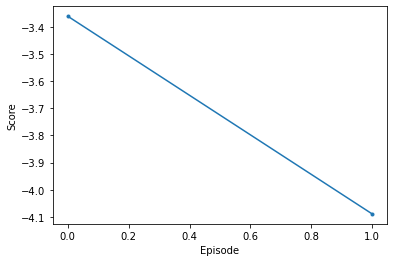

RL episode performed in 295.4522 seconds
Episode 2	Average Score: -3.73
i got the init
action 28 t 0 ep: 3 mi 2.67 reward 0.0 cum 0.0
action 33 t 1 ep: 3 mi 2.66 reward -0.01 cum -0.0
action 41 t 2 ep: 3 mi 2.66 reward -0.0 cum -0.01
action 32 t 3 ep: 3 mi 2.66 reward -0.0 cum -0.01
action 28 t 4 ep: 3 mi 2.66 reward -0.01 cum -0.01
action 44 t 5 ep: 3 mi 2.66 reward -0.0 cum -0.02
action 15 t 6 ep: 3 mi 2.65 reward -0.01 cum -0.03
action 12 t 7 ep: 3 mi 2.65 reward -0.01 cum -0.04
action 28 t 8 ep: 3 mi 2.64 reward -0.02 cum -0.06
action 41 t 9 ep: 3 mi 2.64 reward -0.02 cum -0.08
action 55 t 10 ep: 3 mi 2.63 reward -0.03 cum -0.11
action 43 t 11 ep: 3 mi 2.65 reward -0.01 cum -0.13
action 36 t 12 ep: 3 mi 2.64 reward -0.02 cum -0.15
action 57 t 13 ep: 3 mi 2.65 reward -0.01 cum -0.16
action 25 t 14 ep: 3 mi 2.65 reward -0.01 cum -0.18
action 41 t 15 ep: 3 mi 2.64 reward -0.02 cum -0.2
action 44 t 16 ep: 3 mi 2.64 reward -0.03 cum -0.22
action 12 t 17 ep: 3 mi 2.63 reward -0.03 cum -0

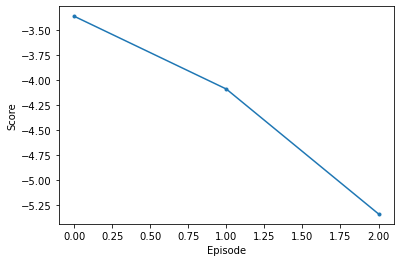

RL episode performed in 292.0844 seconds
Episode 3	Average Score: -4.26
i got the init
action 53 t 0 ep: 4 mi 2.67 reward 0.0 cum 0.0
action 43 t 1 ep: 4 mi 2.67 reward 0.0 cum 0.01
action 23 t 2 ep: 4 mi 2.67 reward 0.01 cum 0.01
action 14 t 3 ep: 4 mi 2.66 reward -0.0 cum 0.01
action 43 t 4 ep: 4 mi 2.66 reward -0.0 cum 0.01
action 53 t 5 ep: 4 mi 2.67 reward -0.0 cum 0.01
action 41 t 6 ep: 4 mi 2.67 reward 0.0 cum 0.01
action 18 t 7 ep: 4 mi 2.67 reward 0.01 cum 0.01
action 14 t 8 ep: 4 mi 2.67 reward 0.0 cum 0.02
action 12 t 9 ep: 4 mi 2.66 reward -0.0 cum 0.01
action 7 t 10 ep: 4 mi 2.67 reward 0.01 cum 0.02
action 12 t 11 ep: 4 mi 2.67 reward 0.0 cum 0.02
action 1 t 12 ep: 4 mi 2.67 reward 0.0 cum 0.02
action 58 t 13 ep: 4 mi 2.66 reward -0.0 cum 0.02
action 55 t 14 ep: 4 mi 2.66 reward -0.01 cum 0.02
action 15 t 15 ep: 4 mi 2.66 reward -0.0 cum 0.01
action 61 t 16 ep: 4 mi 2.66 reward -0.0 cum 0.01
action 17 t 17 ep: 4 mi 2.67 reward 0.0 cum 0.01
action 44 t 18 ep: 4 mi 2.67 rew

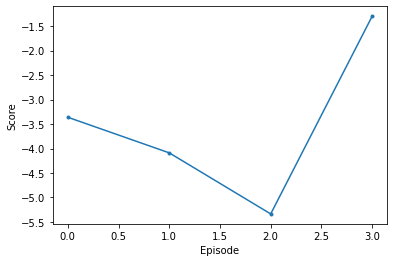

RL episode performed in 295.3425 seconds
Episode 4	Average Score: -3.52
i got the init
action 40 t 0 ep: 5 mi 2.67 reward 0.01 cum 0.01
action 11 t 1 ep: 5 mi 2.67 reward 0.01 cum 0.03
action 44 t 2 ep: 5 mi 2.68 reward 0.02 cum 0.05
action 32 t 3 ep: 5 mi 2.67 reward 0.01 cum 0.06
action 11 t 4 ep: 5 mi 2.67 reward 0.02 cum 0.08
action 10 t 5 ep: 5 mi 2.67 reward 0.01 cum 0.09
action 14 t 6 ep: 5 mi 2.68 reward 0.02 cum 0.12
action 40 t 7 ep: 5 mi 2.67 reward 0.01 cum 0.13
action 61 t 8 ep: 5 mi 2.67 reward 0.01 cum 0.14
action 14 t 9 ep: 5 mi 2.67 reward 0.01 cum 0.16
action 9 t 10 ep: 5 mi 2.67 reward 0.01 cum 0.17
action 53 t 11 ep: 5 mi 2.67 reward 0.02 cum 0.18
action 0 t 12 ep: 5 mi 2.68 reward 0.02 cum 0.2
action 10 t 13 ep: 5 mi 2.67 reward 0.01 cum 0.22
action 14 t 14 ep: 5 mi 2.66 reward 0.01 cum 0.23
action 8 t 15 ep: 5 mi 2.67 reward 0.02 cum 0.24
action 46 t 16 ep: 5 mi 2.68 reward 0.02 cum 0.26
action 1 t 17 ep: 5 mi 2.68 reward 0.02 cum 0.28
action 14 t 18 ep: 5 mi 2.67

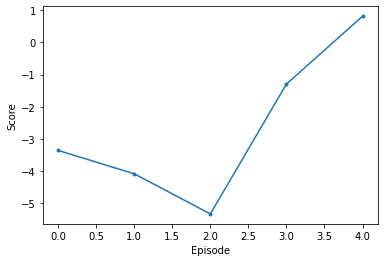

RL episode performed in 298.6342 seconds
Episode 5	Average Score: -2.65
i got the init
action 46 t 0 ep: 6 mi 2.67 reward 0.01 cum 0.01
action 17 t 1 ep: 6 mi 2.67 reward 0.01 cum 0.01
action 10 t 2 ep: 6 mi 2.67 reward 0.0 cum 0.02
action 4 t 3 ep: 6 mi 2.66 reward -0.01 cum 0.01
action 40 t 4 ep: 6 mi 2.66 reward -0.0 cum 0.01
action 32 t 5 ep: 6 mi 2.66 reward -0.01 cum 0.0
action 12 t 6 ep: 6 mi 2.66 reward -0.0 cum -0.0
action 53 t 7 ep: 6 mi 2.66 reward -0.01 cum -0.01
action 7 t 8 ep: 6 mi 2.67 reward 0.0 cum -0.01
action 27 t 9 ep: 6 mi 2.66 reward -0.01 cum -0.01
action 40 t 10 ep: 6 mi 2.66 reward -0.01 cum -0.02
action 22 t 11 ep: 6 mi 2.66 reward -0.01 cum -0.03
action 25 t 12 ep: 6 mi 2.66 reward -0.0 cum -0.03
action 31 t 13 ep: 6 mi 2.66 reward -0.0 cum -0.03
action 53 t 14 ep: 6 mi 2.66 reward -0.0 cum -0.04
action 43 t 15 ep: 6 mi 2.66 reward -0.0 cum -0.04
action 53 t 16 ep: 6 mi 2.66 reward -0.0 cum -0.04
action 31 t 17 ep: 6 mi 2.65 reward -0.01 cum -0.05
action 1 t

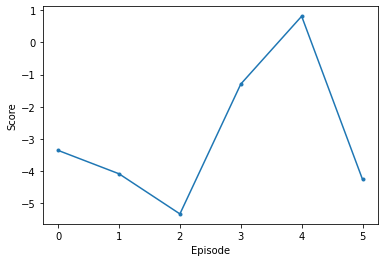

RL episode performed in 288.7981 seconds
Episode 6	Average Score: -2.92
i got the init
action 0 t 0 ep: 7 mi 2.67 reward 0.01 cum 0.01
action 14 t 1 ep: 7 mi 2.67 reward 0.0 cum 0.01
action 31 t 2 ep: 7 mi 2.66 reward -0.0 cum 0.0
action 1 t 3 ep: 7 mi 2.67 reward 0.0 cum 0.0
action 42 t 4 ep: 7 mi 2.66 reward -0.01 cum -0.0
action 53 t 5 ep: 7 mi 2.66 reward -0.01 cum -0.01
action 7 t 6 ep: 7 mi 2.67 reward 0.0 cum -0.01
action 1 t 7 ep: 7 mi 2.66 reward -0.0 cum -0.02
action 15 t 8 ep: 7 mi 2.66 reward -0.0 cum -0.02
action 10 t 9 ep: 7 mi 2.66 reward -0.01 cum -0.03
action 33 t 10 ep: 7 mi 2.65 reward -0.02 cum -0.05
action 54 t 11 ep: 7 mi 2.65 reward -0.02 cum -0.06
action 4 t 12 ep: 7 mi 2.65 reward -0.02 cum -0.08
action 42 t 13 ep: 7 mi 2.64 reward -0.02 cum -0.1
action 0 t 14 ep: 7 mi 2.65 reward -0.02 cum -0.12
action 32 t 15 ep: 7 mi 2.65 reward -0.02 cum -0.14
action 31 t 16 ep: 7 mi 2.64 reward -0.02 cum -0.17
action 63 t 17 ep: 7 mi 2.64 reward -0.03 cum -0.2
action 17 t 

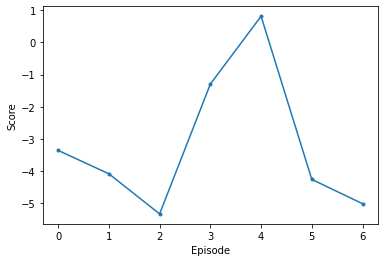

RL episode performed in 288.7520 seconds
Episode 7	Average Score: -3.22
i got the init
action 10 t 0 ep: 8 mi 2.67 reward 0.01 cum 0.01
action 1 t 1 ep: 8 mi 2.66 reward 0.0 cum 0.01
action 0 t 2 ep: 8 mi 2.67 reward 0.01 cum 0.02
action 26 t 3 ep: 8 mi 2.65 reward -0.0 cum 0.01
action 53 t 4 ep: 8 mi 2.66 reward 0.01 cum 0.02
action 14 t 5 ep: 8 mi 2.66 reward 0.0 cum 0.02
action 14 t 6 ep: 8 mi 2.67 reward 0.01 cum 0.03
action 0 t 7 ep: 8 mi 2.66 reward -0.0 cum 0.03
action 24 t 8 ep: 8 mi 2.67 reward 0.01 cum 0.04
action 60 t 9 ep: 8 mi 2.66 reward 0.0 cum 0.04
action 18 t 10 ep: 8 mi 2.66 reward -0.0 cum 0.04
action 27 t 11 ep: 8 mi 2.66 reward 0.0 cum 0.04
action 40 t 12 ep: 8 mi 2.67 reward 0.01 cum 0.05
action 1 t 13 ep: 8 mi 2.66 reward 0.01 cum 0.06
action 32 t 14 ep: 8 mi 2.66 reward 0.0 cum 0.06
action 40 t 15 ep: 8 mi 2.66 reward 0.0 cum 0.07
action 32 t 16 ep: 8 mi 2.67 reward 0.01 cum 0.07
action 26 t 17 ep: 8 mi 2.66 reward -0.0 cum 0.07
action 6 t 18 ep: 8 mi 2.66 rewar

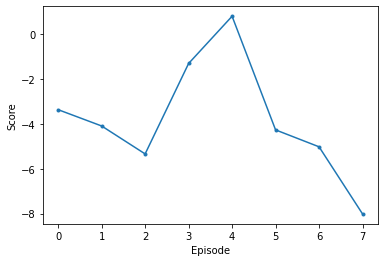

RL episode performed in 289.7671 seconds
Episode 8	Average Score: -3.82
i got the init
action 19 t 0 ep: 9 mi 2.66 reward -0.0 cum -0.0
action 50 t 1 ep: 9 mi 2.66 reward -0.0 cum -0.01
action 56 t 2 ep: 9 mi 2.67 reward 0.0 cum -0.0
action 19 t 3 ep: 9 mi 2.65 reward -0.01 cum -0.01
action 25 t 4 ep: 9 mi 2.65 reward -0.01 cum -0.02
action 32 t 5 ep: 9 mi 2.65 reward -0.01 cum -0.03
action 32 t 6 ep: 9 mi 2.66 reward 0.0 cum -0.03
action 1 t 7 ep: 9 mi 2.66 reward -0.01 cum -0.04
action 40 t 8 ep: 9 mi 2.66 reward 0.0 cum -0.03
action 32 t 9 ep: 9 mi 2.66 reward -0.01 cum -0.04
action 46 t 10 ep: 9 mi 2.67 reward 0.0 cum -0.04
action 32 t 11 ep: 9 mi 2.66 reward -0.01 cum -0.04
action 46 t 12 ep: 9 mi 2.66 reward 0.0 cum -0.04
action 5 t 13 ep: 9 mi 2.66 reward -0.01 cum -0.05
action 10 t 14 ep: 9 mi 2.66 reward -0.01 cum -0.06
action 1 t 15 ep: 9 mi 2.65 reward -0.02 cum -0.07
action 10 t 16 ep: 9 mi 2.63 reward -0.03 cum -0.11
action 49 t 17 ep: 9 mi 2.64 reward -0.02 cum -0.13
acti

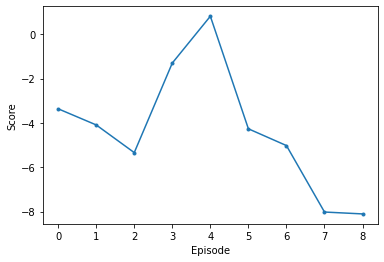

RL episode performed in 289.1235 seconds
Episode 9	Average Score: -4.30
i got the init
action 1 t 0 ep: 10 mi 2.67 reward 0.0 cum 0.0
action 32 t 1 ep: 10 mi 2.66 reward -0.0 cum 0.0
action 46 t 2 ep: 10 mi 2.67 reward 0.0 cum 0.0
action 12 t 3 ep: 10 mi 2.67 reward 0.0 cum 0.0
action 32 t 4 ep: 10 mi 2.67 reward 0.0 cum 0.01
action 32 t 5 ep: 10 mi 2.67 reward 0.0 cum 0.01
action 46 t 6 ep: 10 mi 2.66 reward -0.0 cum 0.01
action 25 t 7 ep: 10 mi 2.66 reward -0.0 cum 0.0
action 10 t 8 ep: 10 mi 2.67 reward 0.0 cum 0.01
action 40 t 9 ep: 10 mi 2.67 reward 0.0 cum 0.01
action 7 t 10 ep: 10 mi 2.67 reward 0.01 cum 0.02
action 10 t 11 ep: 10 mi 2.66 reward -0.01 cum 0.01
action 56 t 12 ep: 10 mi 2.66 reward -0.01 cum 0.01
action 40 t 13 ep: 10 mi 2.66 reward -0.01 cum -0.0
action 56 t 14 ep: 10 mi 2.65 reward -0.01 cum -0.02
action 31 t 15 ep: 10 mi 2.65 reward -0.02 cum -0.04
action 54 t 16 ep: 10 mi 2.65 reward -0.01 cum -0.05
action 17 t 17 ep: 10 mi 2.65 reward -0.01 cum -0.06
action 5

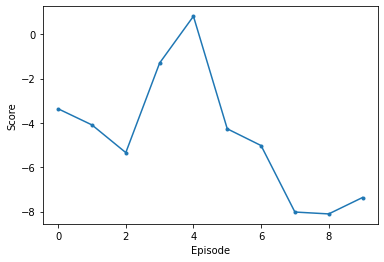

RL episode performed in 293.3235 seconds
Episode 10	Average Score: -4.60
[-3.3612113900043794, -4.088892057887275, -5.3369367903831595, -1.2968920530007608, 0.8132072872702105, -4.263632530029504, -5.019410807980137, -8.017304264877907, -8.101988823224467, -7.362021330453431]


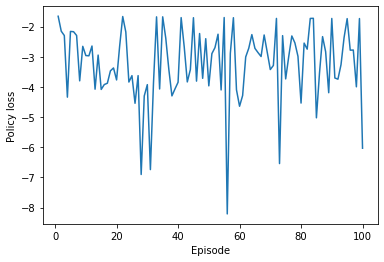

In [19]:
OSNR = 6
M = 16
n_episodes=10;
max_t=100;
gamma=1.0;
print_every=1;

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
policy = Policy(s_size=2*M,h_size=5*M,a_size=4*M).to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

scores = reinforce(OSNR, M, policy, optimizer, n_episodes, max_t, gamma, print_every)